<a href="https://colab.research.google.com/github/SAMYSOSERIOUS/Best-Machine-Learning-Projects-for-Beginners/blob/main/07_Animal_Classification_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
print(tf.__version__)

2.19.0


# Loading the data

In [4]:
!wget https://storage.googleapis.com/adsa-data/animal-classification/animal.zip
!unzip animal.zip -d temp

Streaming output truncated to the last 5000 lines.
  inflating: temp/train/dog.5499.jpg  
  inflating: temp/train/dog.55.jpg   
  inflating: temp/train/dog.550.jpg  
  inflating: temp/train/dog.5500.jpg  
  inflating: temp/train/dog.5501.jpg  
  inflating: temp/train/dog.5502.jpg  
  inflating: temp/train/dog.5503.jpg  
  inflating: temp/train/dog.5504.jpg  
  inflating: temp/train/dog.5505.jpg  
  inflating: temp/train/dog.5506.jpg  
  inflating: temp/train/dog.5507.jpg  
  inflating: temp/train/dog.5508.jpg  
  inflating: temp/train/dog.5509.jpg  
  inflating: temp/train/dog.551.jpg  
  inflating: temp/train/dog.5510.jpg  
  inflating: temp/train/dog.5511.jpg  
  inflating: temp/train/dog.5512.jpg  
  inflating: temp/train/dog.5513.jpg  
  inflating: temp/train/dog.5514.jpg  
  inflating: temp/train/dog.5515.jpg  
  inflating: temp/train/dog.5516.jpg  
  inflating: temp/train/dog.5517.jpg  
  inflating: temp/train/dog.5518.jpg  
  inflating: temp/train/dog.5519.jpg  
  inflating: tem

In [5]:
!mkdir -p data/dog
!mkdir -p data/cat
!cp temp/train/dog.* data/dog/
!cp temp/train/cat.* data/cat/

In [6]:
import os

dog_count = len(os.listdir("./data/dog"))
cat_count = len(os.listdir("./data/cat"))
print("Dog pictures: ", dog_count)
print("Cat pictures: ", cat_count)

Dog pictures:  12500
Cat pictures:  12500


# Load data into Dataset objects

In [7]:
IMAGE_WIDTH=227
IMAGE_HEIGHT=227
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE=32

In [8]:
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

# TODO Use tf.keras.utils.image_dataset_from_directory to assign 80% images to the train dataset
(train_ds, val_ds) = tf.keras.utils.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


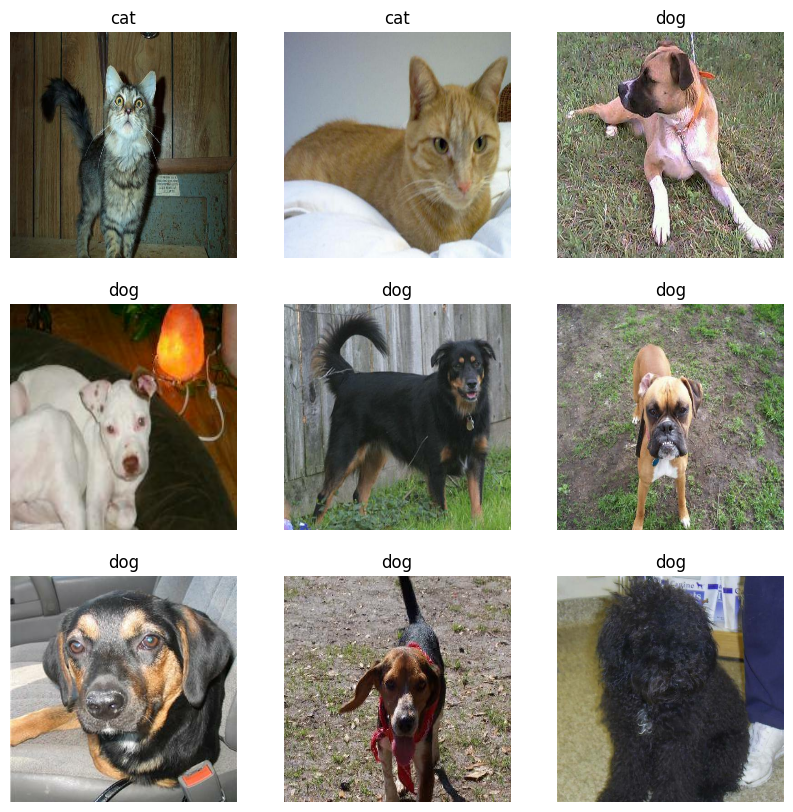

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Preparation

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [22]:
from tensorflow import keras
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# TODO: Design an AlexNet model
model = keras.models.Sequential([
    #rescale layer added to the top
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
    ])

model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,295,042 (222.38 MB)

 Trainable params: 58,292,290 (222.37 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [14]:
epochs = 10

train = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.5803 - loss: 2.4516 - val_accuracy: 0.6026 - val_loss: 0.7691 - learning_rate: 1.0000e-04
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6772 - loss: 0.8225 - val_accuracy: 0.7536 - val_loss: 0.5208 - learning_rate: 1.0000e-04
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7567 - loss: 0.5544 - val_accuracy: 0.7914 - val_loss: 0.4709 - learning_rate: 1.0000e-04
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8194 - loss: 0.4347 - val_accuracy: 0.8304 - val_loss: 0.3998 - learning_rate: 1.0000e-04
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8590 - loss: 0.3467 - val_accuracy: 0.7608 - val_loss: 0.4865 - learning_rate: 1.0000e-04
Epoch 6/10
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8882 - loss: 0.2960
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accurac

# Visualization

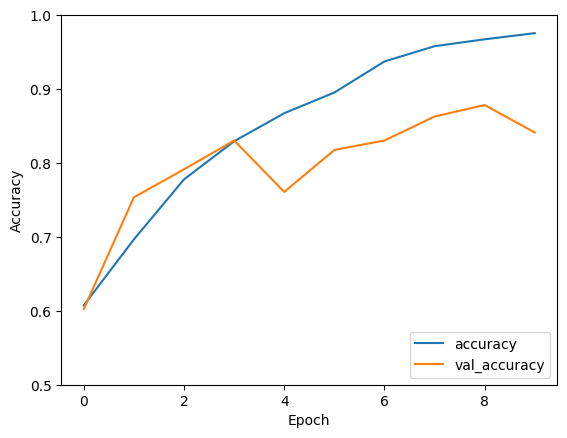

In [15]:
plt.plot(train.history['accuracy'], label='accuracy')
plt.plot(train.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


# Confusion Matrix

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')

# Extract true labels from the validation dataset
true_labels = []
for images, labels in val_ds:
    true_labels.extend(labels.numpy())

cm = confusion_matrix(true_labels, y_pred)
print(cm)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion Matrix
[[2302  141]
 [ 653 1904]]


# Testing

In [18]:
!wget https://storage.googleapis.com/adsa-data/animal-classification/test.zip
!unzip test.zip

--2025-10-27 20:11:04--  https://storage.googleapis.com/adsa-data/animal-classification/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.207, 172.217.214.207, 108.177.121.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370194 (362K) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>] 361.52K   739KB/s    in 0.5s    

2025-10-27 20:11:06 (739 KB/s) - ‘test.zip’ saved [370194/370194]

Archive:  test.zip
   creating: test/
  inflating: test/cat1.jpg           
  inflating: test/cat2.jpg           
  inflating: test/cat3.jpg           
  inflating: test/dog1.jpg           
  inflating: test/dog2.jpg           
  inflating: test/dog3.jpg           


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


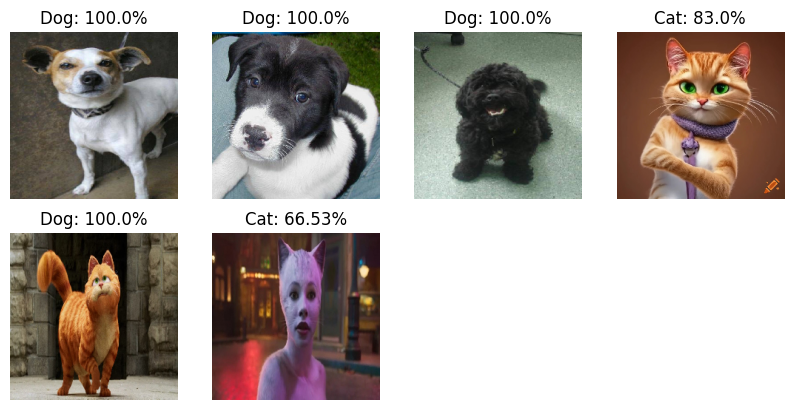

In [19]:
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.figure(figsize=(10, 10))
for i, file in enumerate(glob.glob('test/*')):
    img = load_img(file, target_size=IMAGE_SIZE)

    # convert to array
    img = img_to_array(img)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img.astype("uint8"))

    # reshape into a single sample with 3 channels
    img = img.reshape(1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
    predict = model.predict(img)
    percent = predict[0][0]*100

    result = 'Cat'
    if percent < 50:
        result = 'Dog'
        percent = 100 - percent

    plt.title(result + ": " + str(round(percent, 2)) + "%")
    plt.axis("off")

# Improvement

In [ ]:
# Did you forget to Rescale the images?
# TODO: Add a Rescaling layer at the top of the model
# https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/

In [ ]:
# Did you have Overfit?
# TODO: Try to add some data argumentation layers (RandomZoom, RandomFlip, RandomRotation, RandomTranslation) after the Rescaling layer and train again